# Simple Neural Network


by   
[__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/)  
[Konstantin Ziegler (konstantin.ziegler@uni-passau.de)](http://zieglerk.net)  
Jörg Schlötterer (joerg.schloetterer@uni-passau.de)

with examples taken from the [scikit-learn documentation](http://scikit-learn.org/stable/)

## Introduction
In this tutorial, we will implement a simple 3-layer neural network, based on components and techniques, we have seen so far. This notebook is based on the tutorial [nn from scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/), which uses different activation functions and a softmax in the output layer.

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from scipy.special import expit

# Display plots inline
%matplotlib inline

## Dataset

Besides the datasets we have already worked with, [scikit-learn](http://scikit-learn.org/) provides some functions to generate toy data. Here, we will use [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html), which generates to half-circles.

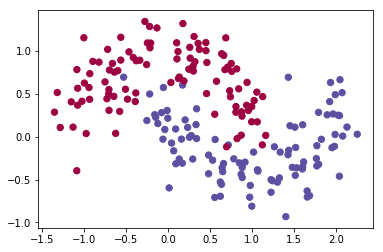

In [47]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

The dataset we generated has two classes, plotted as red and blue points. 

Our goal is to train a NN-classifier that predicts the correct class (red or blue - 0 or 1 respectively) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

## Logistic Regression

For demo purposes, we start with fitting a Logistic Regression classifier from `scikit-learn`.

In [48]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [49]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

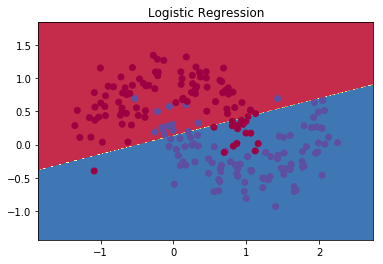

In [50]:
# Plot the decision boundary
plot_decision_boundary(clf.predict)
plt.title("Logistic Regression")
plt.show()

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

## Architecture

We build a 3-layer network with one input layer, one hidden layer and one output layer. 

The number of nodes in the input layer is determined by the dimensionality of our data, which is 2. Since our classification problem is binary, a single neuron in the output is sufficient. In the hidden layer, we are free to choose the number of neurons. The more nodes in the hidden layer, the more complex functions we will be able to fit. On the other hand, increasing the number of nodes in the hidden layer, means increasing the computation effort and we are more prone to overfitting. We will try different sizes of the hidden layer and see how it affects the output. 
We choose the sigmoid as activation function in the hidden and output layer.

<img src="./pics/simple_NN.png"/>

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input (row vector) to our network then we calculate our prediction $\hat{y}$ (one-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 && \text{total input to hidden layer}\\
a_1 & = \mathrm{sigmoid}(z_1) && \text{hidden layer activation} \\
z_2 & = a_1W_2 + b_2 && \text{total input to output layer} \\
a_2 & = \hat{y} = \mathrm{sigmoid}(z_2) && \text{output layer activation}
\end{aligned}
$$

$z_i$ is the input of layer $i$ and $a_i$ is the output of layer $i$ after applying the activation function. $\theta = (W_1, b_1, W_2, b_2)$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times1}$, $b_2 \in \mathbb{R}^{1}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters $(W_1,b_1,W_2,b_2)$ that minimize the error on our training data. We use the Sum Squared Error (SSE) as our loss function:
$$
\begin{aligned}
L(y,\hat{y}) = \frac{1}{2} \sum_{n \in N} (\hat{y}-y)^2
\end{aligned}
$$
with $N$ being the number of training examples, $\hat{y}$ our predicted class and $y$ the true class.

Our goal is to find the parameters that minimize our loss function. We can use batch gradient descent with a fixed learning rate to find its minimum. 

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\nabla\theta = (\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}})$. To calculate these gradients we use backpropagation.

Applying the backpropagation formula we find the following gradients:

$$
\begin{aligned}
& \frac{\partial{L}}{\partial{W_2}} = A_1^T \delta_2  \\
& \frac{\partial{L}}{\partial{b_2}} = \sum \delta_2 \\
& \frac{\partial{L}}{\partial{W_1}} = X^T \delta_1\\
& \frac{\partial{L}}{\partial{b_1}} = \sum \delta_1 \\
\end{aligned}
$$  

$$
\begin{aligned}
& \delta_2 = (\hat{y}-y) \cdot sigmoid(z_2) \cdot (1-sigmoid(z_2) \\
& \delta_1 = \delta_2 \cdot W_2^T \cdot sigmoid(z_1) \cdot (1- sigmoid(z_1)) \\
\end{aligned}
$$

#### Detailed gradients for a single sample

Note, that gradients above are for batch gradient descent, i.e. we sum the error over all our training examples. When we calculate the gradients for a single sample, we do **not account for the sum**. Then we obtain the following gradients:
$$
\begin{aligned}
& \frac{\partial{L}}{\partial{W_2}} = \delta_2 \cdot a_1  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_2 \\
& \frac{\partial{L}}{\partial{W_1}} = \delta_1 \cdot x\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_1 \\
\end{aligned}
$$  

$$
\begin{aligned}
& \delta_2 = (\hat{y}-y) \cdot sigmoid(z_2) \cdot (1-sigmoid(z_2) \\
& \delta_1 = \delta_2 \cdot W_2 \cdot sigmoid(z_1) \cdot (1- sigmoid(z_1)) \\
\end{aligned}
$$  

Recall the network configuration:
$$
\begin{aligned}
z_1 & = xW_1 + b_1 && \text{total input to hidden layer}\\
a_1 & = \mathrm{sigmoid}(z_1) && \text{hidden layer activation} \\
z_2 & = a_1W_2 + b_2 && \text{total input to output layer} \\
a_2 & = \hat{y} = \mathrm{sigmoid}(z_2) && \text{output layer activation}
\end{aligned}
$$

By applying the chain rule, we get:
$$
\begin{aligned}
\frac{\partial{L}}{\partial{W_2}} &= \frac{\partial{L}}{\partial{a_2}} \cdot \frac{\partial{a_2}}{\partial{z_2}} \cdot \frac{\partial{z_2}}{\partial{W_2}}\\
\frac{\partial{L}}{\partial{b_2}} &= \frac{\partial{L}}{\partial{a_2}} \cdot \frac{\partial{a_2}}{\partial{z_2}} \cdot \frac{\partial{z_2}}{\partial{b_2}}\\
\frac{\partial{L}}{\partial{W_1}} &= \frac{\partial{L}}{\partial{a_1}} \cdot \frac{\partial{a_1}}{\partial{z_1}} \cdot \frac{\partial{z_1}}{\partial{W_1}} \\
&= \frac{\partial{L}}{\partial{z_2}} \cdot \frac{\partial{z_2}}{\partial{a_1}} \cdot \frac{\partial{a_1}}{\partial{z_1}} \cdot \frac{\partial{z_1}}{\partial{W_1}} \\
&=  \frac{\partial{L}}{\partial{a_2}} \cdot \frac{\partial{a_2}}{\partial{z_2}} \cdot \frac{\partial{z_2}}{\partial{a_1}} \cdot \frac{\partial{a_1}}{\partial{z_1}} \cdot \frac{\partial{z_1}}{\partial{W_1}}\\
\frac{\partial{L}}{\partial{b_1}} &= \frac{\partial{L}}{\partial{a_1}} \cdot \frac{\partial{a_1}}{\partial{z_1}} \cdot \frac{\partial{z_1}}{\partial{b_1}} \\
&= \frac{\partial{L}}{\partial{z_2}} \cdot \frac{\partial{z_2}}{\partial{a_1}} \cdot \frac{\partial{a_1}}{\partial{z_1}} \cdot \frac{\partial{z_1}}{\partial{b_1}} \\
&=  \frac{\partial{L}}{\partial{a_2}} \cdot \frac{\partial{a_2}}{\partial{z_2}} \cdot \frac{\partial{z_2}}{\partial{a_1}} \cdot \frac{\partial{a_1}}{\partial{z_1}} \cdot \frac{\partial{z_1}}{\partial{b_1}}
\end{aligned}
$$

Calculating the required partial derivatives:

$$
\begin{aligned}
\frac{\partial{L}}{\partial{a_2}} &= \hat{y} - y\\
\frac{\partial{a_2}}{\partial{z_2}} &= sigmoid(z_2) \cdot (1-sigmoid(z_2))\\
\frac{\partial{z_2}}{\partial{W_2}} &= a_1\\
\frac{\partial{z_2}}{\partial{b_2}} &= 1 \\
\frac{\partial{z_2}}{\partial{a_1}} &= W_2 \\
\frac{\partial{a_1}}{\partial{z_1}} &= sigmoid(z_1) \cdot (1-sigmoid(z_1))\\
\frac{\partial{z_1}}{\partial{W_1}} &= x \\
\frac{\partial{z_1}}{\partial{b_1}} &= 1 \\
\end{aligned}
$$

Deltas ($\delta_2,\delta_1$):
$$
\begin{aligned}
\delta_2 &= \frac{\partial{L}}{\partial{a_2}} \cdot \frac{\partial{a_2}}{\partial{z_2}} = (\hat{y}-y) \cdot sigmoid(z_2) \cdot (1-sigmoid(z_2)\\
\delta_1 &= \frac{\partial{L}}{\partial{a_2}} \cdot \frac{\partial{a_2}}{\partial{z_2}} \cdot \frac{\partial{z_2}}{\partial{a_1}} \cdot \frac{\partial{a_1}}{\partial{z_1}} = \delta_2 \cdot W_2 \cdot sigmoid(z_1) \cdot (1- sigmoid(z_1)) \\
\end{aligned}
$$

### Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [51]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 1 # output layer dimensionality
y = np.reshape(y, (num_examples,1)) # adjust the shape of the target values

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [52]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = expit(z1)
    z2 = a1.dot(W2) + b2
    scores = expit(z2)
    # Calculating the loss
    data_loss = np.sum((scores - y)**2)
    # return MSE instead of SSE
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns class 1 if the output is above 0.5. You can think of the output as p, the probability for class 1. The probability for class 0 is then 1-p.

In [53]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = expit(z1)
    z2 = a1.dot(W2) + b2
    score = expit(z2)
    return np.where(score>0.5,1,0)

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [54]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, epsilon=0.01, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = expit(z1)
        z2 = a1.dot(W2) + b2
        scores = expit(z2)
        
        # Backpropagation
        delta2 = (scores-y)*scores*(1-scores)
        dW2 = (a1.T).dot(delta2) # delta2 * a1
        db2 = np.sum(delta2, axis=0, keepdims=True) # delta2
        delta1 = delta2.dot(W2.T) * a1 * (1-a1) # delta2 * W2 * a1 * (1-a1)
        dW1 = np.dot(X.T, delta1) # delta1 * X
        db1 = np.sum(delta1, axis=0)

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss every 1000th iteration.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.252355
Loss after iteration 1000: 0.095652
Loss after iteration 2000: 0.076609
Loss after iteration 3000: 0.045376
Loss after iteration 4000: 0.031550
Loss after iteration 5000: 0.025772
Loss after iteration 6000: 0.022664
Loss after iteration 7000: 0.021072
Loss after iteration 8000: 0.020163
Loss after iteration 9000: 0.019581
Loss after iteration 10000: 0.019175
Loss after iteration 11000: 0.018873
Loss after iteration 12000: 0.018638
Loss after iteration 13000: 0.018448
Loss after iteration 14000: 0.018291
Loss after iteration 15000: 0.018159
Loss after iteration 16000: 0.018046
Loss after iteration 17000: 0.017948
Loss after iteration 18000: 0.017861
Loss after iteration 19000: 0.017785


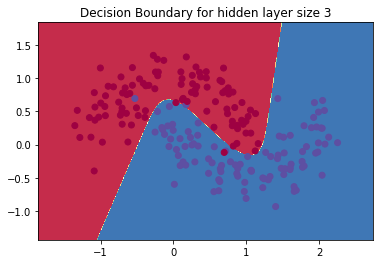

In [55]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

Yay! This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


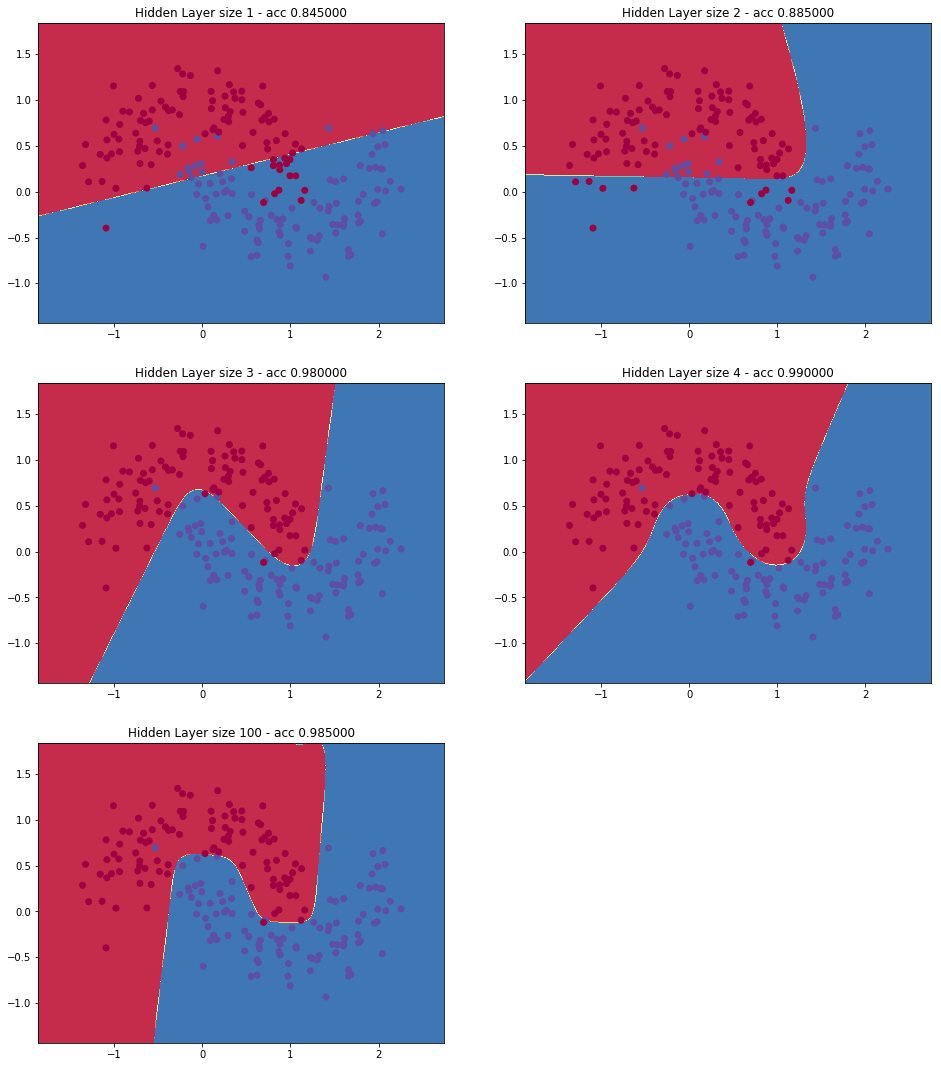

In [56]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 100]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    model = build_model(nn_hdim, epsilon=0.006,num_passes=80000)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.title('Hidden Layer size %d - acc %f' % (nn_hdim,sum(predict(model,X)==y)/num_examples))
plt.show()

The models with only 1 or 2 neurons in the hidden layer are not able to fit a good classifier. But already with 3 neurons in the hidden layer, we have a good separation of the classes. Even with a large number of neurons in the hidden layer, the model does not seem to overfit the data. You may try different model parameters, maybe you can find a configuration that overfits. Nevertheless, following Occam's razor, the simpler models should be preferred. If you want to see a model that overfits, take a look at the source [tutorial](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/). There, tanh is used as activation function of the hidden layer instead of a sigmoid and a softmax in the output (instead of sigmoid).